<img src="https://github.com/hernancontigiani/ceia_memorias_especializacion/raw/master/Figures/logoFIUBA.jpg" width="500" align="center">


# Procesamiento de lenguaje natural
## LSTM Bot QA

### Datos
El objecto es utilizar datos disponibles del challenge ConvAI2 (Conversational Intelligence Challenge 2) de conversaciones en inglés. Se construirá un BOT para responder a preguntas del usuario (QA).\
[LINK](http://convai.io/data/)

In [9]:
!pip install --upgrade --no-cache-dir gdown --quiet

In [10]:
# Instalación de dependencias y configuración inicial
import re
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, LSTM, Dense, Embedding, Dropout
from sklearn.model_selection import train_test_split
import gdown
import os

print("TensorFlow version:", tf.__version__)

TensorFlow version: 2.18.0


In [11]:
# Descarga del dataset
def download_dataset():
    """Descarga el dataset de conversaciones si no existe"""
    if not os.path.exists('data_volunteers.json'):
        print("Descargando dataset...")
        url = 'https://drive.google.com/uc?id=1awUxYwImF84MIT5-jCaYAPe2QwSgS1hN&export=download'
        gdown.download(url, 'data_volunteers.json', quiet=False)
        print("Dataset descargado exitosamente!")
    else:
        print("El dataset ya existe")

download_dataset()

El dataset ya existe


In [12]:
# Carga y exploración del dataset
def load_and_explore_data():
    """Carga el dataset y muestra información básica"""
    with open('data_volunteers.json', 'r') as f:
        data = json.load(f)

    print(f"Número total de conversaciones: {len(data)}")
    print(f"Campos disponibles en cada conversación: {list(data[0].keys())}")
    print(f"Ejemplo de diálogo: {data[0]['dialog'][:2]}")

    return data

data = load_and_explore_data()

Número total de conversaciones: 1111
Campos disponibles en cada conversación: ['dialog', 'start_time', 'end_time', 'bot_profile', 'user_profile', 'eval_score', 'profile_match', 'participant1_id', 'participant2_id']
Ejemplo de diálogo: [{'id': 0, 'sender': 'participant1', 'text': 'hi there', 'evaluation_score': None, 'sender_class': 'Human'}]


In [13]:
# Parámetros de configuración (siguiendo recomendaciones + ClariQ insights)
# Parámetros recomendados del ejercicio
MAX_VOCAB_SIZE = 8000
MAX_LENGTH = 10          # max_length ~ 10 según recomendaciones
EMBEDDING_DIM = 300      # Embeddings 300 FastText
N_UNITS = 128            # n_units = 128
LSTM_DROPOUT = 0.2       # LSTM Dropout 0.2
EPOCHS = 50              # Epochs 30~50

# Parámetros adicionales inspirados en ClariQ Challenge
CONFIDENCE_THRESHOLD = 0.3    # Umbral para detectar preguntas ambiguas
CLARIFICATION_ENABLED = True  # Habilitar preguntas clarificatorias
MIN_RESPONSE_LENGTH = 2       # Longitud mínima de respuesta en palabras

print("=== PARÁMETROS DE CONFIGURACIÓN ===")
print(f"MAX_VOCAB_SIZE: {MAX_VOCAB_SIZE}")
print(f"MAX_LENGTH: {MAX_LENGTH}")
print(f"EMBEDDING_DIM: {EMBEDDING_DIM}")
print(f"N_UNITS: {N_UNITS}")
print(f"LSTM_DROPOUT: {LSTM_DROPOUT}")
print(f"EPOCHS: {EPOCHS}")
print(f"CONFIDENCE_THRESHOLD: {CONFIDENCE_THRESHOLD}")
print(f"CLARIFICATION_ENABLED: {CLARIFICATION_ENABLED}")

=== PARÁMETROS DE CONFIGURACIÓN ===
MAX_VOCAB_SIZE: 8000
MAX_LENGTH: 10
EMBEDDING_DIM: 300
N_UNITS: 128
LSTM_DROPOUT: 0.2
EPOCHS: 50
CONFIDENCE_THRESHOLD: 0.3
CLARIFICATION_ENABLED: True


In [14]:
# Función de limpieza de texto mejorada
def clean_text(txt):
    """
    Limpia y normaliza el texto de entrada
    """
    if not isinstance(txt, str):
        return ""

    txt = txt.lower()

    # Expansiones de contracciones
    txt = txt.replace("'d", " had")
    txt = txt.replace("'s", " is")
    txt = txt.replace("'m", " am")
    txt = txt.replace("'re", " are")
    txt = txt.replace("'ve", " have")
    txt = txt.replace("'ll", " will")
    txt = txt.replace("don't", "do not")
    txt = txt.replace("won't", "will not")
    txt = txt.replace("can't", "cannot")

    # Remover caracteres especiales excepto espacios
    txt = re.sub(r'[^\w\s]', ' ', txt)

    # Remover espacios múltiples
    txt = re.sub(r'\s+', ' ', txt)

    return txt.strip()

In [15]:
# Extracción y preparación de pares pregunta-respuesta
def extract_qa_pairs(data, max_len=MAX_LENGTH):
    """
    Extrae pares de pregunta-respuesta del dataset
    """
    input_sentences = []
    output_sentences = []
    output_sentences_inputs = []

    for conversation in data:
        dialog = conversation['dialog']

        # Procesar cada par pregunta-respuesta en el diálogo
        for i in range(len(dialog) - 1):
            question = clean_text(dialog[i]['text'])
            answer = clean_text(dialog[i + 1]['text'])

            # Filtrar por longitud
            if len(question.split()) >= max_len or len(answer.split()) >= max_len:
                continue

            if len(question.strip()) == 0 or len(answer.strip()) == 0:
                continue

            # Preparar secuencias
            # Entrada: pregunta sin tokens especiales
            input_sentence = question

            # Salida para decoder: respuesta con <eos>
            output_sentence = answer + ' <eos>'

            # Entrada para decoder: respuesta con <sos>
            output_sentence_input = '<sos> ' + answer

            input_sentences.append(input_sentence)
            output_sentences.append(output_sentence)
            output_sentences_inputs.append(output_sentence_input)

    return input_sentences, output_sentences, output_sentences_inputs

# Extraer pares Q&A
input_sentences, output_sentences, output_sentences_inputs = extract_qa_pairs(data)

print(f"Cantidad de pares Q&A extraídos: {len(input_sentences)}")
print("\n=== EJEMPLOS ===")
for i in range(3):
    print(f"Pregunta: {input_sentences[i]}")
    print(f"Respuesta (decoder output): {output_sentences[i]}")
    print(f"Respuesta (decoder input): {output_sentences_inputs[i]}")
    print("-" * 50)

Cantidad de pares Q&A extraídos: 8977

=== EJEMPLOS ===
Pregunta: hello
Respuesta (decoder output): hi how are you <eos>
Respuesta (decoder input): <sos> hi how are you
--------------------------------------------------
Pregunta: hi how are you
Respuesta (decoder output): not bad and you <eos>
Respuesta (decoder input): <sos> not bad and you
--------------------------------------------------
Pregunta: i love music i love taylor swift
Respuesta (decoder output): me too and what about iggy pop <eos>
Respuesta (decoder input): <sos> me too and what about iggy pop
--------------------------------------------------


### 2 - Preprocesamiento
Realizar el preprocesamiento necesario para obtener:
- word2idx_inputs, max_input_len
- word2idx_outputs, max_out_len, num_words_output
- encoder_input_sequences, decoder_output_sequences, decoder_targets

In [16]:
# Tokenización unificada (MEJORA 1: Un solo tokenizador)
def create_unified_tokenizer(input_sentences, output_sentences, output_sentences_inputs):
    """
    Crea UN SOLO tokenizador para todo el vocabulario
    MEJORA: En lugar de tokenizadores separados, usamos uno unificado
    """
    # Combinar todos los textos para crear vocabulario unificado
    all_texts = input_sentences + output_sentences + output_sentences_inputs

    # Crear tokenizador unificado
    tokenizer = Tokenizer(num_words=MAX_VOCAB_SIZE,
                         filters='',  # No filtrar porque ya limpiamos
                         lower=False, # Ya está en minúsculas
                         oov_token='<unk>')

    tokenizer.fit_on_texts(all_texts)

    print(f"Vocabulario total: {len(tokenizer.word_index)}")
    print(f"Vocabulario usado: {min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)}")

    return tokenizer

# Crear tokenizador unificado
tokenizer = create_unified_tokenizer(input_sentences, output_sentences, output_sentences_inputs)


Vocabulario total: 3031
Vocabulario usado: 3032


In [17]:
# Conversión a secuencias y padding
def prepare_sequences(tokenizer, input_sentences, output_sentences, output_sentences_inputs):
    """
    Convierte texto a secuencias numéricas y aplica padding
    """
    # Convertir a secuencias
    encoder_input_sequences = tokenizer.texts_to_sequences(input_sentences)
    decoder_output_sequences = tokenizer.texts_to_sequences(output_sentences)
    decoder_input_sequences = tokenizer.texts_to_sequences(output_sentences_inputs)

    # Calcular longitudes máximas
    max_encoder_len = max(len(seq) for seq in encoder_input_sequences)
    max_decoder_len = max(len(seq) for seq in decoder_output_sequences)

    print(f"Longitud máxima encoder: {max_encoder_len}")
    print(f"Longitud máxima decoder: {max_decoder_len}")

    # Aplicar padding
    encoder_input_data = pad_sequences(encoder_input_sequences,
                                      maxlen=max_encoder_len,
                                      padding='post')

    decoder_input_data = pad_sequences(decoder_input_sequences,
                                      maxlen=max_decoder_len,
                                      padding='post')

    decoder_target_data = pad_sequences(decoder_output_sequences,
                                       maxlen=max_decoder_len,
                                       padding='post')

    return (encoder_input_data, decoder_input_data, decoder_target_data,
            max_encoder_len, max_decoder_len)

# Preparar secuencias
encoder_input_data, decoder_input_data, decoder_target_data, max_encoder_len, max_decoder_len = prepare_sequences(
    tokenizer, input_sentences, output_sentences, output_sentences_inputs
)

print(f"Shape encoder input: {encoder_input_data.shape}")
print(f"Shape decoder input: {decoder_input_data.shape}")
print(f"Shape decoder target: {decoder_target_data.shape}")

Longitud máxima encoder: 9
Longitud máxima decoder: 10
Shape encoder input: (8977, 9)
Shape decoder input: (8977, 10)
Shape decoder target: (8977, 10)


In [18]:
# Preparación de targets one-hot
def prepare_one_hot_targets(decoder_target_data, vocab_size):
    """
    Convierte targets a formato one-hot para entrenamiento
    """
    num_samples, max_len = decoder_target_data.shape
    decoder_target_one_hot = np.zeros((num_samples, max_len, vocab_size), dtype='float32')

    for i, sequence in enumerate(decoder_target_data):
        for t, word_index in enumerate(sequence):
            if word_index > 0:                                 # Ignorar padding (índice 0)
                decoder_target_one_hot[i, t, word_index] = 1.0

    return decoder_target_one_hot

# Preparar targets one-hot
vocab_size = min(MAX_VOCAB_SIZE, len(tokenizer.word_index) + 1)
decoder_target_one_hot = prepare_one_hot_targets(decoder_target_data, vocab_size)

print(f"Tamaño del vocabulario: {vocab_size}")
print(f"Shape decoder target one-hot: {decoder_target_one_hot.shape}")


Tamaño del vocabulario: 3032
Shape decoder target one-hot: (8977, 10, 3032)


### 3 - Preparar los embeddings
Utilizar los embeddings de Glove o FastText para transformar los tokens de entrada en vectores

In [19]:
# Carga de embeddings pre-entrenados (opcional FastText)
def load_fasttext_embeddings(vocab_size, embedding_dim, word_index):
    """
    Carga embeddings de FastText (opcional)
    Por ahora retorna embeddings aleatorios, pero se puede extender
    """
    # Matriz de embeddings aleatoria (placeholder)
    # En implementación real, cargarías FastText aquí
    embedding_matrix = np.random.uniform(-0.1, 0.1, (vocab_size, embedding_dim))

    # El token de padding (índice 0) debe ser cero
    embedding_matrix[0] = np.zeros(embedding_dim)

    print(f"Matriz de embeddings creada: {embedding_matrix.shape}")
    return embedding_matrix

# Crear matriz de embeddings
embedding_matrix = load_fasttext_embeddings(vocab_size, EMBEDDING_DIM, tokenizer.word_index)


Matriz de embeddings creada: (3032, 300)


### 4 - Entrenar el modelo
Entrenar un modelo basado en el esquema encoder-decoder utilizando los datos generados en los puntos anteriores. Utilce como referencias los ejemplos vistos en clase.

In [20]:
# Definición del modelo Seq2Seq (MEJORA 2: Embeddings compartidos)
def create_seq2seq_model(vocab_size, embedding_dim, embedding_matrix, max_encoder_len, max_decoder_len, n_units, dropout_rate):
    """
    Crea modelo Seq2Seq con embeddings compartidos
    MEJORA: Una sola capa de embedding para encoder y decoder
    """

    # CAPA DE EMBEDDING COMPARTIDA (MEJORA 2)
    shared_embedding = Embedding(
        input_dim=vocab_size,
        output_dim=embedding_dim,
        weights=[embedding_matrix],
        mask_zero=True,
        trainable=True,  # Permitir fine-tuning
        name='shared_embedding'
    )

    # ============ ENCODER ===============================================================
    encoder_inputs = Input(shape=(max_encoder_len,), name='encoder_inputs')
    encoder_embedding = shared_embedding(encoder_inputs)  # Usar embedding compartido

    encoder_lstm = LSTM(
        n_units,
        return_state=True,
        dropout=dropout_rate,
        name='encoder_lstm'
    )
    encoder_outputs, state_h, state_c = encoder_lstm(encoder_embedding)
    encoder_states = [state_h, state_c]

    # ============ DECODER ===============================================================
    decoder_inputs = Input(shape=(max_decoder_len,), name='decoder_inputs')
    decoder_embedding = shared_embedding(decoder_inputs)  # Usar embedding compartido

    decoder_lstm = LSTM(
        n_units,
        return_sequences=True,
        return_state=True,
        dropout=dropout_rate,
        name='decoder_lstm'
    )
    decoder_outputs, _, _ = decoder_lstm(decoder_embedding, initial_state=encoder_states)

    decoder_dense = Dense(vocab_size, activation='softmax', name='decoder_dense')
    decoder_outputs = decoder_dense(decoder_outputs)

    # Modelo completo para entrenamiento
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs, name='seq2seq_model')

    # ============ MODELOS PARA INFERENCIA ===============================================

    # Modelo encoder para inferencia
    encoder_model = Model(encoder_inputs, encoder_states, name='encoder_model')

    # Modelo decoder para inferencia
    decoder_state_input_h = Input(shape=(n_units,), name='decoder_state_h')
    decoder_state_input_c = Input(shape=(n_units,), name='decoder_state_c')
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]

    # Para inferencia, el decoder recibe una palabra a la vez
    decoder_inputs_single = Input(shape=(1,), name='decoder_inputs_single')
    decoder_embedding_single = shared_embedding(decoder_inputs_single)

    decoder_outputs_inf, state_h_inf, state_c_inf = decoder_lstm(
        decoder_embedding_single, initial_state=decoder_states_inputs
    )
    decoder_states_inf = [state_h_inf, state_c_inf]
    decoder_outputs_inf = decoder_dense(decoder_outputs_inf)

    decoder_model = Model(
        [decoder_inputs_single] + decoder_states_inputs,
        [decoder_outputs_inf] + decoder_states_inf,
        name='decoder_model'
    )

    return model, encoder_model, decoder_model

# Crear modelos
model, encoder_model, decoder_model = create_seq2seq_model(
    vocab_size=vocab_size,
    embedding_dim=EMBEDDING_DIM,
    embedding_matrix=embedding_matrix,
    max_encoder_len=max_encoder_len,
    max_decoder_len=max_decoder_len,
    n_units=N_UNITS,
    dropout_rate=LSTM_DROPOUT
)

In [21]:
# Compilación y resumen del modelo
model.compile(
    optimizer='adam',
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

print("=== ARQUITECTURA DEL MODELO ===")
model.summary()

=== ARQUITECTURA DEL MODELO ===


Model: "seq2seq_model"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ decoder_inputs      │ (None, 10)        │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_inputs      │ (None, 9)         │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ shared_embedding    │ (None, 1, 300)    │    909,600 │ encoder_inputs[0… │
│ (Embedding)         │                   │            │ decoder_inputs[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ not_equal           │ (None, 9)         │          0 │ encoder_inputs[0… │
│ (NotEqual)          │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ encoder_lstm (LSTM) │ [(None, 128),     │    219,648 │ shared_embedding… │
│                     │ (None, 128),      │            │ not_equal[0][0]   │
│                     │ (None, 128)]      │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_lstm (LSTM) │ [(None, 1, 128),  │    219,648 │ shared_embedding… │
│                     │ (None, 128),      │            │ encoder_lstm[0][… │
│                     │ (None, 128)]      │            │ encoder_lstm[0][… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ decoder_dense       │ (None, 1, 3032)   │    391,128 │ decoder_lstm[0][… │
│ (Dense)             │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 1,740,024 (6.64 MB)

 Trainable params: 1,740,024 (6.64 MB)

 Non-trainable params: 0 (0.00 B)

In [22]:
# División de datos y entrenamiento
def split_and_train(model, encoder_input_data, decoder_input_data, decoder_target_one_hot, epochs):
    """
    Divide los datos y entrena el modelo
    """
    # División train/validation
    (encoder_train, encoder_val,
     decoder_input_train, decoder_input_val,
     decoder_target_train, decoder_target_val) = train_test_split(
        encoder_input_data,
        decoder_input_data,
        decoder_target_one_hot,
        test_size=0.2,
        random_state=42
    )

    print(f"Datos de entrenamiento: {encoder_train.shape[0]}")
    print(f"Datos de validación: {encoder_val.shape[0]}")

    # Entrenamiento
    print("Iniciando entrenamiento...")
    history = model.fit(
        [encoder_train, decoder_input_train],
        decoder_target_train,
        batch_size=64,
        epochs=epochs,
        validation_data=([encoder_val, decoder_input_val], decoder_target_val),
        verbose=1
    )

    return history

# Entrenar modelo
history = split_and_train(model, encoder_input_data, decoder_input_data, decoder_target_one_hot, EPOCHS)


Datos de entrenamiento: 7181
Datos de validación: 1796
Iniciando entrenamiento...
Epoch 1/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 9s 27ms/step - accuracy: 0.0983 - loss: 6.2565 - val_accuracy: 0.1282 - val_loss: 4.5702
Epoch 2/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.1349 - loss: 4.4189 - val_accuracy: 0.1696 - val_loss: 4.1770
Epoch 3/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - accuracy: 0.1812 - loss: 3.9813 - val_accuracy: 0.2062 - val_loss: 3.8548
Epoch 4/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 5s 22ms/step - accuracy: 0.2110 - loss: 3.6645 - val_accuracy: 0.2212 - val_loss: 3.6584
Epoch 5/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2263 - loss: 3.4062 - val_accuracy: 0.2335 - val_loss: 3.5088
Epoch 6/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - accuracy: 0.2371 - loss: 3.2870 - val_accuracy: 0.2459 - val_loss: 3.4146
Epoch 7/50
113/113 ━━━━━━━━━━━━━━━━━━━━ 3s 26ms/step - accuracy: 0.2505 - loss: 3.1259 - val_accuracy: 0.2500 - val_loss: 3.3344
Epoch 8/50
113/

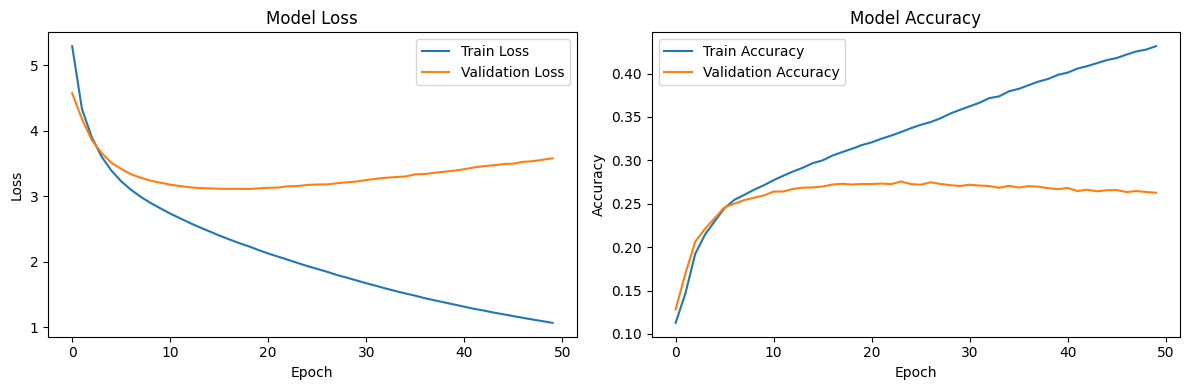

In [23]:
# Visualización del entrenamiento
def plot_training_history(history):
    """
    Visualiza la evolución del entrenamiento
    """
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Loss
    ax1.plot(history.history['loss'], label='Train Loss')
    ax1.plot(history.history['val_loss'], label='Validation Loss')
    ax1.set_title('Model Loss')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Loss')
    ax1.legend()

    # Accuracy
    ax2.plot(history.history['accuracy'], label='Train Accuracy')
    ax2.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax2.set_title('Model Accuracy')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Accuracy')
    ax2.legend()

    plt.tight_layout()
    plt.show()

plot_training_history(history)

### 5 - Inferencia
Experimentar el funcionamiento de su modelo. Recuerde que debe realizar la inferencia de los modelos por separado de encoder y decoder.

In [24]:
# Funciones de clarificación y respuesta

# Función para detectar necesidad de clarificación
def needs_clarification(question, confidence_score):
    """
    Determina si una pregunta necesita clarificación
    Basado en insights del ClariQ Challenge (RQ1: When to ask clarifying questions?)
    """
    # Factores que indican necesidad de clarificación:

    # 1. Baja confianza en la respuesta
    if confidence_score < CONFIDENCE_THRESHOLD:
        return True

    # 2. Preguntas muy generales o ambiguas (palabras clave)
    ambiguous_keywords = [
        'what', 'how', 'tell me about', 'information about',
        'something', 'anything', 'everything', 'general'
    ]

    question_lower = question.lower()
    if any(keyword in question_lower for keyword in ambiguous_keywords):
        # Si la pregunta es muy corta y contiene palabras ambiguas
        if len(question.split()) <= 3:
            return True

    # 3. Preguntas con múltiples interpretaciones posibles
    multi_meaning_words = ['bank', 'mouse', 'java', 'python', 'apple']
    if any(word in question_lower for word in multi_meaning_words):
        return True

    return False

# Banco de preguntas clarificatorias
def generate_clarification_question(original_question):
    """
    Genera preguntas clarificatorias relevantes
    Inspirado en ClariQ Challenge (RQ2: How to generate clarifying questions?)
    """
    question_lower = original_question.lower()

    # Banco de preguntas clarificatorias por contexto
    clarification_bank = {
        'location': [
            "Are you asking about a specific location?",
            "Do you want information about where something is located?",
            "Are you looking for directions or address information?"
        ],
        'definition': [
            "Are you looking for a definition or explanation?",
            "Do you want to know what something means?",
            "Are you asking about the purpose or function?"
        ],
        'how_to': [
            "Are you looking for step-by-step instructions?",
            "Do you want to know the process or method?",
            "Are you asking about requirements or prerequisites?"
        ],
        'comparison': [
            "Are you comparing different options?",
            "Do you want to know similarities or differences?",
            "Are you looking for recommendations?"
        ],
        'general': [
            "Could you be more specific about what you want to know?",
            "What particular aspect interests you most?",
            "Are you looking for basic or detailed information?"
        ]
    }

    # Detectar contexto de la pregunta
    if any(word in question_lower for word in ['where', 'location', 'place']):
        context = 'location'
    elif any(word in question_lower for word in ['what is', 'define', 'meaning']):
        context = 'definition'
    elif any(word in question_lower for word in ['how to', 'how can', 'steps']):
        context = 'how_to'
    elif any(word in question_lower for word in ['vs', 'versus', 'compare', 'better']):
        context = 'comparison'
    else:
        context = 'general'

    # Seleccionar pregunta clarificatoria aleatoria del contexto
    import random
    return random.choice(clarification_bank[context])

# Función de inferencia mejorada (inspirada en ClariQ)
def decode_sequence(input_seq, encoder_model, decoder_model, tokenizer, max_decoder_len):
    """
    Genera respuesta usando los modelos de inferencia
    Incluye detección de confianza para preguntas clarificatorias
    """
    # Obtener estados del encoder
    states_value = encoder_model.predict(input_seq, verbose=0)

    # Secuencia inicial del decoder (token <sos>)
    target_seq = np.zeros((1, 1))
    target_seq[0, 0] = tokenizer.word_index.get('<sos>', 1)

    # Generar secuencia palabra por palabra
    decoded_sentence = ''
    stop_condition = False
    confidence_scores = []  # Para trackear confianza

    while not stop_condition:
        output_tokens, h, c = decoder_model.predict([target_seq] + states_value, verbose=0)

        # Obtener token con mayor probabilidad y su score
        probabilities = output_tokens[0, -1, :]
        sampled_token_index = np.argmax(probabilities)
        confidence_score = np.max(probabilities)
        confidence_scores.append(confidence_score)

        # Obtener palabra correspondiente
        sampled_word = None
        for word, index in tokenizer.word_index.items():
            if sampled_token_index == index:
                sampled_word = word
                break

        if sampled_word is None:
            sampled_word = '<unk>'

        # Verificar condiciones de parada
        if sampled_word == '<eos>' or len(decoded_sentence.split()) >= max_decoder_len:
            stop_condition = True
        else:
            decoded_sentence += sampled_word + ' '

        # Actualizar secuencia objetivo
        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = sampled_token_index

        # Actualizar estados
        states_value = [h, c]

    # Calcular confianza promedio
    avg_confidence = np.mean(confidence_scores) if confidence_scores else 0.0

    return decoded_sentence.strip(), avg_confidence

In [25]:
# Mejora para chatear con el bot (con clarificación)
def chat_with_bot(question, tokenizer, encoder_model, decoder_model, max_encoder_len, max_decoder_len):
    """
    Función principal para interactuar con el bot
    Incluye sistema de preguntas clarificatorias basado en ClariQ Challenge
    """
    # Limpiar y tokenizar la pregunta
    cleaned_question = clean_text(question)
    input_seq = tokenizer.texts_to_sequences([cleaned_question])
    input_seq = pad_sequences(input_seq, maxlen=max_encoder_len, padding='post')

    # Generar respuesta con score de confianza
    response, confidence = decode_sequence(input_seq, encoder_model, decoder_model, tokenizer, max_decoder_len)

    # Verificar si necesita clarificación
    if CLARIFICATION_ENABLED and needs_clarification(question, confidence):
        clarification = generate_clarification_question(question)
        return f"[CLARIFICATION NEEDED] {clarification}", confidence

    # Verificar calidad de la respuesta
    if len(response.split()) < MIN_RESPONSE_LENGTH:
        return "I'm not sure I understand. Could you rephrase your question?", confidence

    return response, confidence

# Función para conversaciones multi-turno
def multi_turn_chat(questions_list, tokenizer, encoder_model, decoder_model, max_encoder_len, max_decoder_len):
    """
    Maneja conversaciones de múltiples turnos
    Inspirado en Stage 2 del ClariQ Challenge
    """
    conversation_history = []

    for i, question in enumerate(questions_list):
        print(f"\n--- TURNO {i+1} ---")
        print(f"Usuario: {question}")

        response, confidence = chat_with_bot(question, tokenizer, encoder_model, decoder_model, max_encoder_len, max_decoder_len)

        print(f"Bot: {response}")
        print(f"Confianza: {confidence:.3f}")

        # Guardar en historial
        conversation_history.append({
            'turn': i+1,
            'user_input': question,
            'bot_response': response,
            'confidence': confidence,
            'needs_clarification': '[CLARIFICATION NEEDED]' in response
        })

    return conversation_history

In [26]:
# Pruebas del bot mejoradas (EVALUACIÓN REQUERIDA + ClariQ insights)
print("\n" + "="*60)
print("EVALUACIÓN DEL BOT - PREGUNTAS DE PRUEBA")
print("Incluye sistema de clarificación inspirado en ClariQ Challenge")
print("="*60)

# Preguntas sugeridas en el ejercicio + casos de clarificación
test_questions = [
    # Preguntas originales del ejercicio
    "Do you read?",
    "Do you have any pet?",
    "Where are you from?",

    # Preguntas adicionales para funcionalidad básica
    "What is your name?",
    "How are you?",
    "What do you like?",
    "Tell me about yourself",
    "Do you work?",

    # Casos que pueden requerir clarificación (inspirados en ClariQ)
    "What about java?",  # Ambiguo: ¿lenguaje o café?
    "Tell me something",  # Muy general
    "Information",  # Incompleto
    "Where?",  # Sin contexto
    "How?",  # Sin contexto específico
    "What is that?",  # Referencia ambigua
]

evaluation_results = []

print("\n=== EVALUACIÓN INDIVIDUAL ===")
for i, question in enumerate(test_questions, 1):
    response, confidence = chat_with_bot(question, tokenizer, encoder_model, decoder_model, max_encoder_len, max_decoder_len)

    # Determinar si es clarificación o respuesta directa
    is_clarification = '[CLARIFICATION NEEDED]' in response
    response_clean = response.replace('[CLARIFICATION NEEDED] ', '')

    print(f"{i:2d}. Q: {question}")
    if is_clarification:
        print(f"    A: [CLARIFICATION] {response_clean}")
    else:
        print(f"    A: {response_clean}")
    print(f"    Confianza: {confidence:.3f}")
    print("-" * 50)

    # Guardar para análisis
    evaluation_results.append({
        'question': question,
        'response': response_clean,
        'confidence': confidence,
        'is_clarification': is_clarification,
        'question_length': len(question.split()),
        'response_length': len(response_clean.split())
    })

# Análisis de resultados
print("\n=== ANÁLISIS DE RESULTADOS ===")
import pandas as pd

df_results = pd.DataFrame(evaluation_results)

print(f"Total de preguntas evaluadas: {len(df_results)}")
print(f"Respuestas directas: {len(df_results[~df_results['is_clarification']])}")
print(f"Preguntas clarificatorias: {len(df_results[df_results['is_clarification']])}")
print(f"Confianza promedio: {df_results['confidence'].mean():.3f}")
print(f"Longitud promedio de respuesta: {df_results['response_length'].mean():.1f} palabras")

# Mostrar casos de clarificación
clarification_cases = df_results[df_results['is_clarification']]
if len(clarification_cases) > 0:
    print(f"\n=== CASOS QUE REQUIRIERON CLARIFICACIÓN ===")
    for _, case in clarification_cases.iterrows():
        print(f"- '{case['question']}' (confianza: {case['confidence']:.3f})")

# Prueba de conversación multi-turno
print(f"\n=== PRUEBA DE CONVERSACIÓN MULTI-TURNO ===")
multi_turn_questions = [
    "What about programming?",  # Ambiguo
    "I mean Python programming",  # Clarificación del usuario
    "Do you know any programming languages?",  # Seguimiento
]

conversation = multi_turn_chat(multi_turn_questions, tokenizer, encoder_model, decoder_model, max_encoder_len, max_decoder_len)

# Mostrar resumen de la conversación
print(f"\n=== RESUMEN DE CONVERSACIÓN MULTI-TURNO ===")
for turn in conversation:
    status = "CLARIFICACIÓN" if turn['needs_clarification'] else "RESPUESTA"
    print(f"Turno {turn['turn']}: {status} (confianza: {turn['confidence']:.3f})")



EVALUACIÓN DEL BOT - PREGUNTAS DE PRUEBA
Incluye sistema de clarificación inspirado en ClariQ Challenge

=== EVALUACIÓN INDIVIDUAL ===
 1. Q: Do you read?
    A: i do not have any hobbies
    Confianza: 0.522
--------------------------------------------------
 2. Q: Do you have any pet?
    A: I'm not sure I understand. Could you rephrase your question?
    Confianza: 0.529
--------------------------------------------------
 3. Q: Where are you from?
    A: i am from the united states how about you
    Confianza: 0.725
--------------------------------------------------
 4. Q: What is your name?
    A: my name is mary what is yours
    Confianza: 0.725
--------------------------------------------------
 5. Q: How are you?
    A: [CLARIFICATION] What particular aspect interests you most?
    Confianza: 0.816
--------------------------------------------------
 6. Q: What do you like?
    A: i like to play video games
    Confianza: 0.821
--------------------------------------------------

In [27]:
# Evaluación interactiva avanzada
def interactive_chat():
    """
    Modo interactivo mejorado para chatear con el bot
    Incluye comandos especiales y análisis de conversación
    """
    print("\n=== CHAT INTERACTIVO AVANZADO ===")
    print("Comandos especiales:")
    print("- 'quit' o 'exit': Salir del chat")
    print("- 'stats': Mostrar estadísticas de la conversación")
    print("- 'confidence on/off': Activar/desactivar mostrar confianza")
    print("- 'clarify on/off': Activar/desactivar preguntas clarificatorias")
    print("-" * 50)

    conversation_log = []
    show_confidence = True
    global CLARIFICATION_ENABLED

    while True:
        question = input("\nTú: ").strip()

        # Comandos especiales
        if question.lower() in ['quit', 'exit']:
            break
        elif question.lower() == 'stats':
            print(f"\n=== ESTADÍSTICAS DE CONVERSACIÓN ===")
            if conversation_log:
                df_conv = pd.DataFrame(conversation_log)
                print(f"Mensajes enviados: {len(df_conv)}")
                print(f"Confianza promedio: {df_conv['confidence'].mean():.3f}")
                print(f"Clarificaciones solicitadas: {df_conv['is_clarification'].sum()}")
                print(f"Longitud promedio respuesta: {df_conv['response_length'].mean():.1f} palabras")
            else:
                print("No hay conversación aún.")
            continue
        elif question.lower() == 'confidence on':
            show_confidence = True
            print("✅ Mostrar confianza activado")
            continue
        elif question.lower() == 'confidence off':
            show_confidence = False
            print("❌ Mostrar confianza desactivado")
            continue
        elif question.lower() == 'clarify on':
            CLARIFICATION_ENABLED = True
            print("✅ Preguntas clarificatorias activadas")
            continue
        elif question.lower() == 'clarify off':
            CLARIFICATION_ENABLED = False
            print("❌ Preguntas clarificatorias desactivadas")
            continue
        elif question.strip() == '':
            continue

        # Procesar pregunta normal
        response, confidence = chat_with_bot(question, tokenizer, encoder_model, decoder_model, max_encoder_len, max_decoder_len)

        # Mostrar respuesta
        is_clarification = '[CLARIFICATION NEEDED]' in response
        response_clean = response.replace('[CLARIFICATION NEEDED] ', '')

        if is_clarification:
            print(f"Bot: 🤔 {response_clean}")
        else:
            print(f"Bot: {response_clean}")

        if show_confidence:
            confidence_emoji = "🟢" if confidence > 0.7 else "🟡" if confidence > 0.4 else "🔴"
            print(f"     {confidence_emoji} Confianza: {confidence:.3f}")

        # Guardar en log
        conversation_log.append({
            'question': question,
            'response': response_clean,
            'confidence': confidence,
            'is_clarification': is_clarification,
            'response_length': len(response_clean.split())
        })

    # Mostrar resumen final
    if conversation_log:
        print(f"\n=== RESUMEN FINAL ===")
        df_final = pd.DataFrame(conversation_log)
        print(f"Total mensajes: {len(df_final)}")
        print(f"Confianza promedio: {df_final['confidence'].mean():.3f}")
        print(f"Clarificaciones: {df_final['is_clarification'].sum()}")
        print("¡Gracias por chatear!")

# Función de evaluación automática con métricas
def evaluate_bot_performance(test_questions_with_expected=None):
    """
    Evaluación automática del bot con métricas cuantitativas
    Inspirado en métricas del ClariQ Challenge
    """
    print("\n=== EVALUACIÓN AUTOMÁTICA DEL BOT ===")

    if test_questions_with_expected is None:
        # Conjunto básico de pruebas con respuestas esperadas (keywords)
        test_questions_with_expected = [
            ("Do you read?", ["yes", "no", "books", "reading"]),
            ("What is your name?", ["name", "called", "i am", "my name"]),
            ("Where are you from?", ["from", "live", "place", "location"]),
            ("How are you?", ["fine", "good", "well", "ok", "great"]),
            ("Do you work?", ["work", "job", "yes", "no"]),
        ]

    metrics = {
        'total_questions': len(test_questions_with_expected),
        'responses_generated': 0,
        'relevant_responses': 0,
        'clarifications_needed': 0,
        'avg_confidence': 0.0,
        'avg_response_length': 0.0
    }

    confidences = []
    response_lengths = []

    for question, expected_keywords in test_questions_with_expected:
        response, confidence = chat_with_bot(question, tokenizer, encoder_model, decoder_model, max_encoder_len, max_decoder_len)

        metrics['responses_generated'] += 1
        confidences.append(confidence)

        # Limpiar respuesta para análisis
        is_clarification = '[CLARIFICATION NEEDED]' in response
        response_clean = response.replace('[CLARIFICATION NEEDED] ', '').lower()
        response_lengths.append(len(response_clean.split()))

        if is_clarification:
            metrics['clarifications_needed'] += 1

        # Verificar relevancia (si contiene alguna keyword esperada)
        if any(keyword in response_clean for keyword in expected_keywords):
            metrics['relevant_responses'] += 1

        print(f"Q: {question}")
        print(f"A: {response}")
        print(f"Relevante: {'✅' if any(keyword in response_clean for keyword in expected_keywords) else '❌'}")
        print("-" * 40)

    # Calcular métricas finales
    metrics['avg_confidence'] = np.mean(confidences)
    metrics['avg_response_length'] = np.mean(response_lengths)
    metrics['relevance_rate'] = metrics['relevant_responses'] / metrics['total_questions']
    metrics['clarification_rate'] = metrics['clarifications_needed'] / metrics['total_questions']

    # Mostrar resumen
    print(f"\n=== MÉTRICAS FINALES ===")
    print(f"Preguntas procesadas: {metrics['total_questions']}")
    print(f"Respuestas relevantes: {metrics['relevant_responses']}/{metrics['total_questions']} ({metrics['relevance_rate']:.1%})")
    print(f"Clarificaciones solicitadas: {metrics['clarifications_needed']} ({metrics['clarification_rate']:.1%})")
    print(f"Confianza promedio: {metrics['avg_confidence']:.3f}")
    print(f"Longitud promedio de respuesta: {metrics['avg_response_length']:.1f} palabras")

    return metrics

# Ejecutar evaluación automática
bot_metrics = evaluate_bot_performance()

print("\n=== INSTRUCCIONES DE USO ===")
print("Para chatear interactivamente, descomenta la siguiente línea:")
print("# interactive_chat()")
print("\nPara habilitar/deshabilitar funcionalidades:")
print("- CLARIFICATION_ENABLED = True/False")
print("- CONFIDENCE_THRESHOLD = 0.1 a 0.9 (ajustar sensibilidad)")


=== EVALUACIÓN AUTOMÁTICA DEL BOT ===
Q: Do you read?
A: i do not have any hobbies
Relevante: ✅
----------------------------------------
Q: What is your name?
A: my name is mary what is yours
Relevante: ✅
----------------------------------------
Q: Where are you from?
A: i am from the united states how about you
Relevante: ✅
----------------------------------------
Q: How are you?
A: [CLARIFICATION NEEDED] Could you be more specific about what you want to know?
Relevante: ❌
----------------------------------------
Q: Do you work?
A: i do not have a great day
Relevante: ✅
----------------------------------------

=== MÉTRICAS FINALES ===
Preguntas procesadas: 5
Respuestas relevantes: 4/5 (80.0%)
Clarificaciones solicitadas: 1 (20.0%)
Confianza promedio: 0.701
Longitud promedio de respuesta: 8.0 palabras

=== INSTRUCCIONES DE USO ===
Para chatear interactivamente, descomenta la siguiente línea:
# interactive_chat()

Para habilitar/deshabilitar funcionalidades:
- CLARIFICATION_ENABLED = 

In [28]:
interactive_chat()


=== CHAT INTERACTIVO AVANZADO ===
Comandos especiales:
- 'quit' o 'exit': Salir del chat
- 'stats': Mostrar estadísticas de la conversación
- 'confidence on/off': Activar/desactivar mostrar confianza
- 'clarify on/off': Activar/desactivar preguntas clarificatorias
--------------------------------------------------

Tú: how are you
Bot: 🤔 Are you looking for basic or detailed information?
     🟡 Confianza: 0.579

Tú: how old are you
Bot: i am 32 and what about you
     🟡 Confianza: 0.593

Tú: what is your name
Bot: my name is lucy what is yours
     🟢 Confianza: 0.764

Tú: what is your favorite movie
Bot: i like to read and you
     🟡 Confianza: 0.517

Tú: i dont like read
Bot: what do you like to do
     🟢 Confianza: 0.824

Tú: i like see wach movies
Bot: that is awesome what is your favorite color
     🟡 Confianza: 0.555

Tú: exit

=== RESUMEN FINAL ===
Total mensajes: 6
Confianza promedio: 0.639
Clarificaciones: 1
¡Gracias por chatear!
